In [1]:
#!pip install segmentation-models

In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### part4 open patches

In [ ]:
# output_file = os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
# tifffile.imsave(output_file, img_patches_sub)

# output_file = os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
# tifffile.imsave(output_file, mask_patches_sub)

In [3]:
folder_path = 'soph_annot_multiDS_7_25_23'

name = '5_24'
ds_name = name
img_patches_sub = tifffile.imread(os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name)))
mask_patches_sub = tifffile.imread(os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name)))



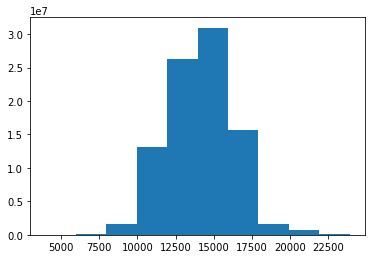

In [4]:
plt.hist(img_patches_sub.flatten(),bins = 10);

In [5]:
def center_norm_im_float32(images):
    images_float = images.astype(np.float32)
    mean = np.mean(images_float)
    std = np.std(images_float)
    normalized_stack = (images_float-mean)/std
    return normalized_stack
img_patches_sub = center_norm_im_float32(img_patches_sub)
mask_patches_sub = mask_patches_sub.astype(np.float32)



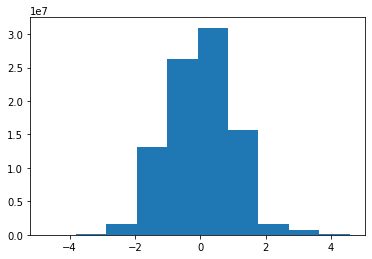

In [6]:
plt.hist(img_patches_sub.flatten(),bins = 10);

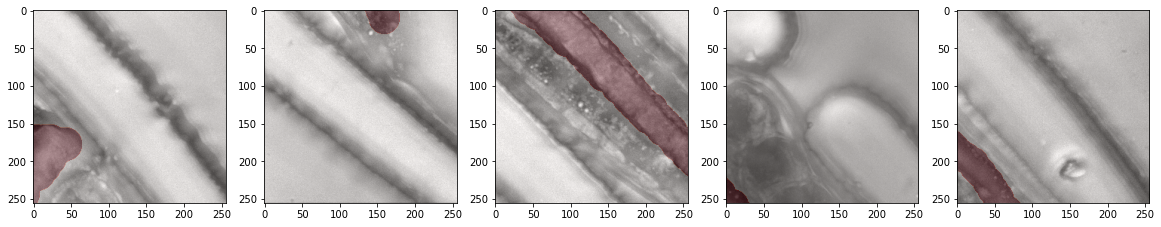

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,img_patches_sub.shape[0])
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(img_patches_sub, mask_patches_sub, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(1034, 256, 256)
(345, 256, 256)


In [11]:
X_train = np.stack((X_train,)*1, axis=-1)
y_train = np.stack((y_train,)*1, axis=-1)

print(X_train.shape)
print(y_train.shape)

(1034, 256, 256, 1)
(1034, 256, 256, 1)


In [12]:
X_test = np.stack((X_test,)*1, axis=-1)
y_test = np.stack((y_test,)*1, axis=-1)
print(X_test.shape)
print(y_test.shape)

(345, 256, 256, 1)
(345, 256, 256, 1)


In [13]:
#New generator with rotation where interpolation that comes with rotation are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size = 32

img_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))
                         #featurewise_center = True,
                         #featurewise_std_normalization = True)#,
                         #preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))


mask_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         brightness_range = (0.95,1.05),
                         preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed,batch_size = batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed,batch_size = batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed,batch_size = batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed,batch_size = batch_size)

In [14]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

x batch: (32, 256, 256, 1)
y batch: (32, 256, 256, 1)


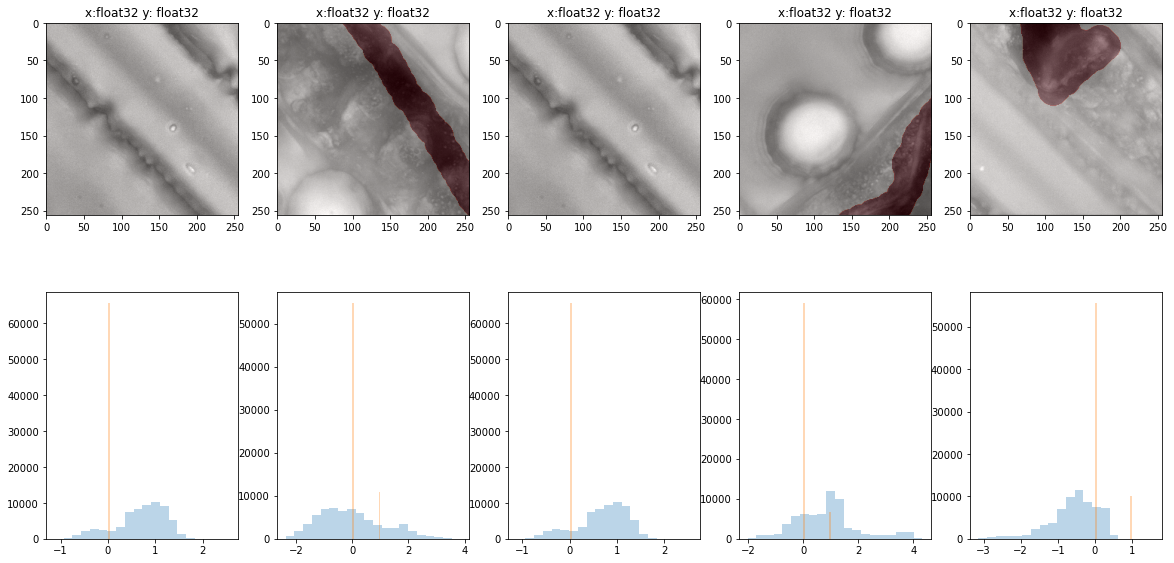

In [15]:
x = image_generator.next()
y = mask_generator.next()

print('x batch:', x.shape)
print('y batch:', y.shape)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,32)
    axs[0,i].imshow(x[ri,...,0], cmap='gray')
    axs[0,i].imshow(y[ri,...,0], cmap='Reds', alpha=0.3)
    axs[0,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
#     axs[1,i].imshow(x[ri+1,...,0], cmap='gray')
#     axs[1,i].imshow(y[i+1,...,0], cmap='Reds', alpha=0.3)
#     axs[1,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
    axs[1,i].hist(x[ri,...,0].flatten(), bins = 20,alpha = 0.3)
    axs[1,i].hist(y[ri,...,0].flatten(), bins = 20,alpha = 0.3)

plt.show()

In [16]:
x[0,0,0,0]

0.24728203

In [19]:
def get_1c_PT_unet(weights_path):
    N = 1
    BACKBONE = 'resnet18'
    preprocess_input1 = sm.get_preprocessing(BACKBONE)
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet')
    inp = Input(shape =(None,None, N))
    l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
    out = base_model(l1)
    model = Model(inp, out, name=base_model.name)
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
    #checkpoint_path = 'models/bf_to_gut_tl/set4patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
    checkpoint_path = weights_path
    model.load_weights(checkpoint_path)
    return model

ppp = 'models/bf_to_gut_tl/set4_50im_patches256_meanstdNorm_imgenBR05_backresnet18_weightimagenetFencoder4ep_v4.hdf5'
model = get_1c_PT_unet(ppp)

In [20]:
checkpoint_path = 'models/bf_to_gut_tl/base_set4_50im_p256_v4_FT_set5_ds_{}_v1.hdf5'.format(ds_name)

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True,mode='min')

# logdirectory
log_fname = 'models/bf_to_gut_tl/base_set4_50im_p256_v4_FT_set5_ds_{}_v1.csv'.format(ds_name)
csvlogger = CSVLogger(filename=log_fname, separator=",", append=True)

directory = os.path.dirname(log_fname)
if not os.path.exists(directory):
    os.makedirs(directory)
with open(log_fname, 'w') as f:
    pass

In [21]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     6         
_________________________________________________________________
model_5 (Model)              (None, None, None, 1)     14340570  
Total params: 14,340,576
Trainable params: 14,330,650
Non-trainable params: 9,926
_________________________________________________________________


In [23]:
# from segmentation_models.utils import set_trainable
# set_trainable(model)

In [22]:
# # set all layers trainable and recompile with same call to compile as before
# for layer in model.layers:
#     layer.trainable = True
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
# # default learning rate is 0.0001

In [23]:
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=50,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/50
32/32 [==============================] - 10s 298ms/step - loss: 0.7525 - iou_score: 0.4680 - val_loss: 0.8379 - val_iou_score: 0.5010
Epoch 2/50
32/32 [==============================] - 8s 235ms/step - loss: 0.5489 - iou_score: 0.5794 - val_loss: 0.6340 - val_iou_score: 0.5545
Epoch 3/50
32/32 [==============================] - 7s 234ms/step - loss: 0.4874 - iou_score: 0.6223 - val_loss: 0.5393 - val_iou_score: 0.6051
Epoch 4/50
32/32 [==============================] - 7s 217ms/step - loss: 0.4408 - iou_score: 0.6584 - val_loss: 0.5102 - val_iou_score: 0.6152
Epoch 5/50
32/32 [==============================] - 7s 210ms/step - loss: 0.3969 - iou_score: 0.6962 - val_loss: 0.4779 - val_iou_score: 0.6338
Epoch 6/50
32/32 [==============================] - 7s 216ms/step - loss: 0.3364 - iou_score: 0.7401 - val_loss: 0.4383 - val_iou_score: 0.6728
Epoch 7/50
32/32 [==============================] - 7s 210ms/step - loss: 0.2954 - iou_score: 0.7702 - val_loss: 0.4658 - val_iou_score

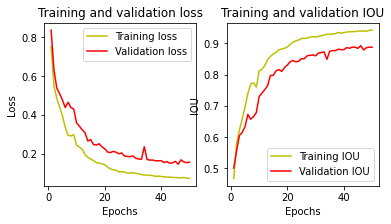

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize = [6,3])
plt.subplot(121)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']
plt.subplot(122)
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()



In [27]:
model.load_weights(checkpoint_path)

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8859915208254067


In [36]:
model.load_weights(checkpoint_path)

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8720188252303179


(256, 256, 1)


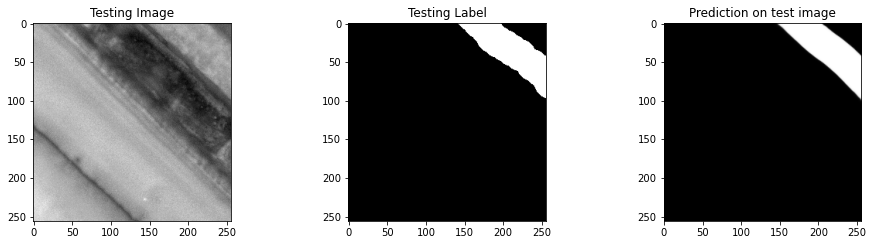

In [28]:

test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=30,
                    callbacks=[checkpoint,csvlogger])

In [32]:
worm_imgs_norm = center_norm_im_float32(worm_imgs_norm) #global_norm_data_float32(bf_stack)
mask_imgs_norm = mask_imgs_norm.astype(np.float32)

4.2384415

23


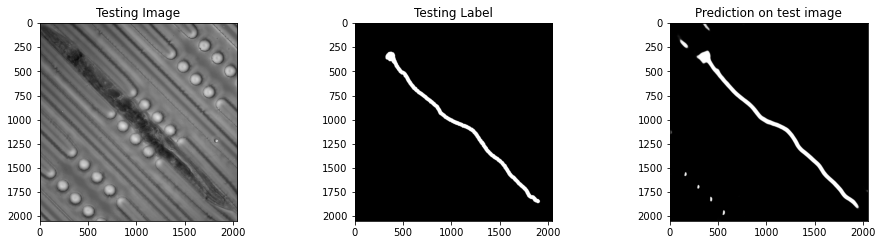

In [34]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
print(test_img_number)
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

4


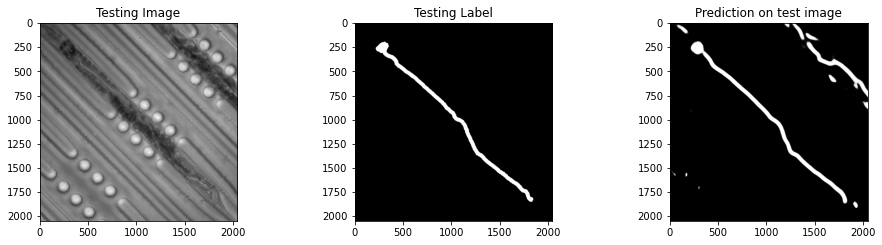

In [35]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
print(test_img_number)
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [61]:
model.load_weights('models/bf_to_gut_tl/sel_patches_backresnet18_weightimagenet_v1.hdf5')


In [62]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8341554104238993


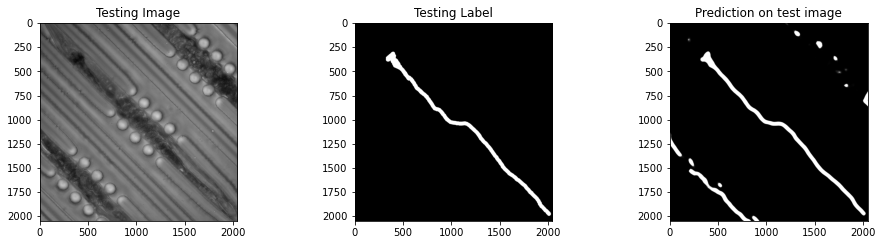

In [63]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

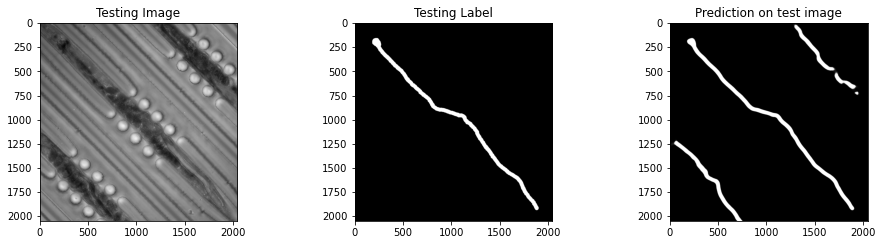

In [64]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

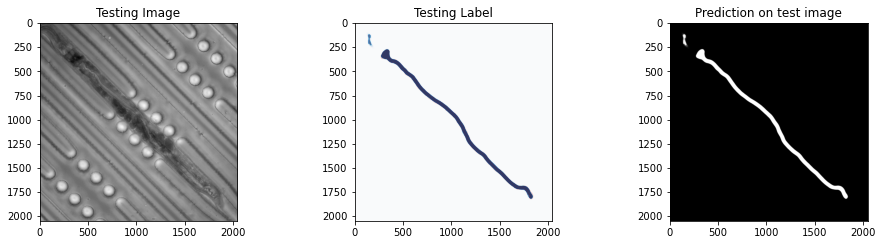

In [67]:
test_img_number = np.random.randint(0, worm_imgs_norm.shape[0])
test_img = worm_imgs_norm[test_img_number,...]

test_img = np.stack((test_img,)*1, axis=-1)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=mask_imgs_norm[test_img_number,...]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='Reds',alpha = 0.7)
plt.imshow(prediction, cmap='Blues',alpha = 0.7)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [80]:
annot_dir = 'soph_annot_bact_noPool_7_22_23'
annot_file_list = os.listdir(annot_dir)
annot_file_list

s1 = tifffile.imread(os.path.join(annot_dir,annot_file_list[3]))
s1.shape

(4, 2048, 2048)

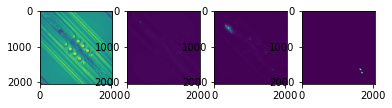

In [81]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(s1[i])

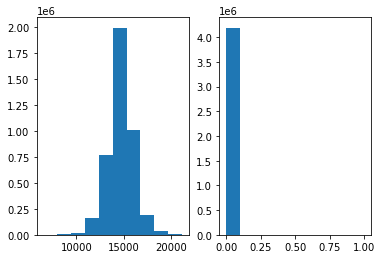

In [82]:
plt.subplot(1,2,1)
plt.hist(s1[0].flatten(),bins = 10);
plt.subplot(1,2,2)
plt.hist(s1[3].flatten(),bins = 10);


In [83]:
bf_norm = global_norm_data_float32(s1[:1,...])

In [84]:
test_img = np.stack((bf_norm,)*1, axis=-1)
test_img.shape

(1, 2048, 2048, 1)

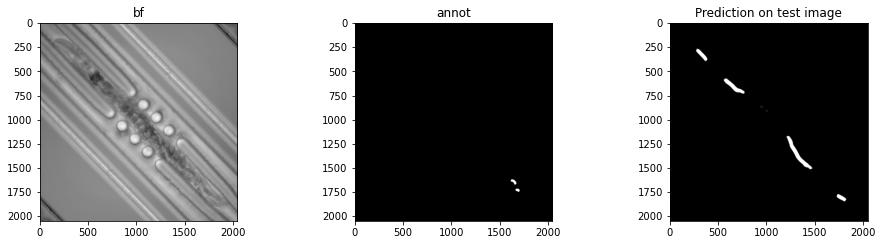

In [85]:



plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('bf')
plt.imshow(test_img[0,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('annot')
plt.imshow(s1[3], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(model.predict(test_img)[0,...,0], cmap='gray')